# Visualizing Simulation Results
### Authors:
##### Justin Tung:      'https://github.com/JayTongue'
##### Matt Adam-Houser: 'https://github.com/mhouser42'

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
import pickle
import networkx as nx
import ipywidgets
from ipywidgets import widgets

from run_simulation import infestation_main  # Custom function from run_simulation.py
from visualization_functions import *

---------------------------------
----------------------------------
# 1. Running and Visualizing One Simulation

Sample output from one simulation of the infestation code:

In [2]:
months_run = 84
run_mode = 'Baseline'
simulation_df = infestation_main(run_mode, months_run) # Change this to change the number of months
simulation_df

,County,month 0,month 1,month 2,month 3,month 4,month 5,month 6,month 7,month 8,...,month 75,month 76,month 77,month 78,month 79,month 80,month 81,month 82,month 83,month 84
0,Cook,0.3,7.226822e-02,9.670873e-03,9.671019e-03,9.671141e-03,3.400000e-01,4.200000e-01,4.207226e-01,4.220275e-01,...,4.685487e-02,4.685940e-02,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,DuPage,0.0,4.415328e-04,4.945032e-05,5.354310e-05,5.642088e-05,6.851481e-03,2.287129e-02,2.950832e-02,4.490895e-02,...,9.106016e-03,9.230004e-03,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,Kane,0.1,5.493235e-03,1.097659e-03,1.103905e-03,1.109202e-03,6.291573e-02,9.321468e-02,1.014448e-01,1.127229e-01,...,2.043103e-02,2.052103e-02,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,Will,0.0,2.965443e-04,4.246409e-05,4.463588e-05,5.150274e-05,8.954608e-03,2.046658e-02,3.265723e-02,3.453427e-02,...,1.581477e-03,1.654330e-03,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4,Winnebago,0.0,0.000000e+00,7.044569e-13,8.401286e-13,9.530868e-13,0.000000e+00,0.000000e+00,8.199257e-07,3.285227e-06,...,6.802722e-03,6.926531e-03,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,Henderson,0.0,2.505593e-08,8.646002e-09,1.209557e-08,1.663200e-08,1.166559e-11,2.651865e-11,2.536977e-10,5.534002e-10,...,4.167456e-03,4.206454e-03,0.038923,0.066110,0.107630,0.190905,0.268418,0.332412,0.403118,0.457227
98,Calhoun,0.0,0.000000e+00,9.205705e-245,7.058495e-146,1.165098e-144,2.415361e-243,1.292481e-214,3.812859e-102,2.138704e-88,...,8.565855e-07,8.577129e-07,0.000005,0.000063,0.000328,0.000862,0.002050,0.003654,0.005254,0.008228
99,Schuyler,0.0,2.971559e-61,4.370661e-21,1.969324e-20,1.445812e-19,4.533323e-28,2.232594e-26,2.081224e-22,2.572436e-20,...,8.252282e-03,8.253617e-03,0.385831,0.560636,0.605036,0.665112,0.746148,0.804866,0.855136,0.928106
100,Gallatin,0.0,0.000000e+00,1.653956e-11,2.045093e-11,2.642541e-11,0.000000e+00,3.172406e-04,1.160155e-03,6.088029e-03,...,3.923812e-03,3.945550e-03,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


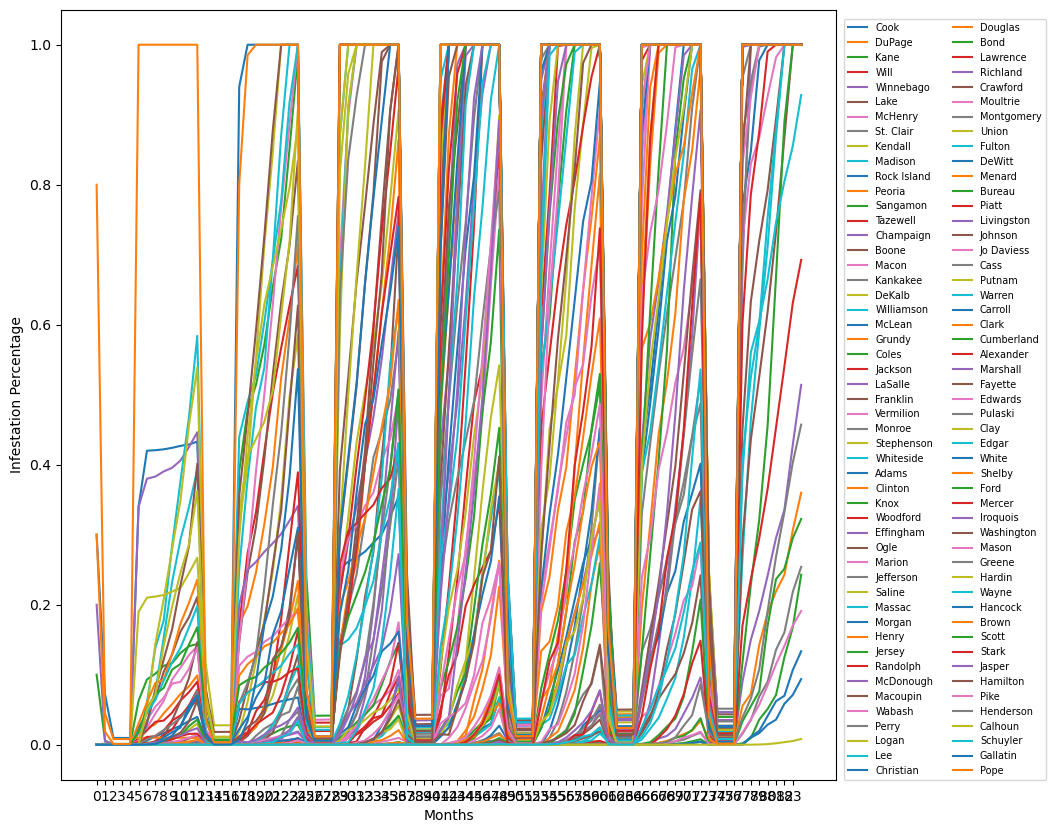

In [3]:
visual_df = make_visual_df(simulation_df)

# Make plots for each county
plt.figure(figsize=(10,10))
for county in visual_df.columns:
    plt.plot(visual_df.index, visual_df[county])
plt.xticks(ticks=range(0, months_run),
    labels=range(0, months_run))
plt.xlabel('Months')
plt.ylabel('Infestation Percentage')
plt.legend(visual_df.columns, loc=(1.01, 0), fontsize=7, ncol=2)
plt.show()

This graph is not very helpful. Since there are 102 Counties in Illinois, the resulting graph is messy and visually confusing. 

An alternative way of visualizing this data may be with a sort of heatmap instead

In [4]:
path = 'data/location'
edges = pd.read_csv(f'{path}/county_edges.csv')

CG = pickle.load(open(f'{path}/IL_graph.dat', 'rb'))
handler = pickle.load(open(f'{path}/graph_handler_counties.dat', 'rb'))
highways = pickle.load(open(f'{path}/osmnx_highways.dat', 'rb'))

In [5]:
widgets.interact(make_network_heat,
                 CG=widgets.fixed(CG),
                 handler=widgets.fixed(handler),
                 simulation_df=widgets.fixed(simulation_df),
                 month=widgets.IntSlider(min=0, max=months_run - 1, step=1, layout=widgets.Layout(width='800px')),
)

interactive(children=(IntSlider(value=0, description='month', layout=Layout(width='800px'), max=83), Output())…

<function visualization_functions.make_network_heat(CG, simulation_df, handler, month: int)>

In order to better see the flow of infestations from week to week, we animated the slider:

In [6]:
play = widgets.interact(make_network_heat,
                        CG=widgets.fixed(CG),
                        handler=widgets.fixed(handler),
                        simulation_df=widgets.fixed(simulation_df),month=widgets.Play(value=0,
                                                                                      min=0,
                                                                                      max=months_run - 1,
                                                                                      step=1,
                                                                                      interval=500,
                                                                                      disabled=False,
                                                                                     ))

interactive(children=(Play(value=0, description='month', interval=500, max=83), Output()), _dom_classes=('widg…

Showing the infestation of the state as a whole is more helpful than each individual county:

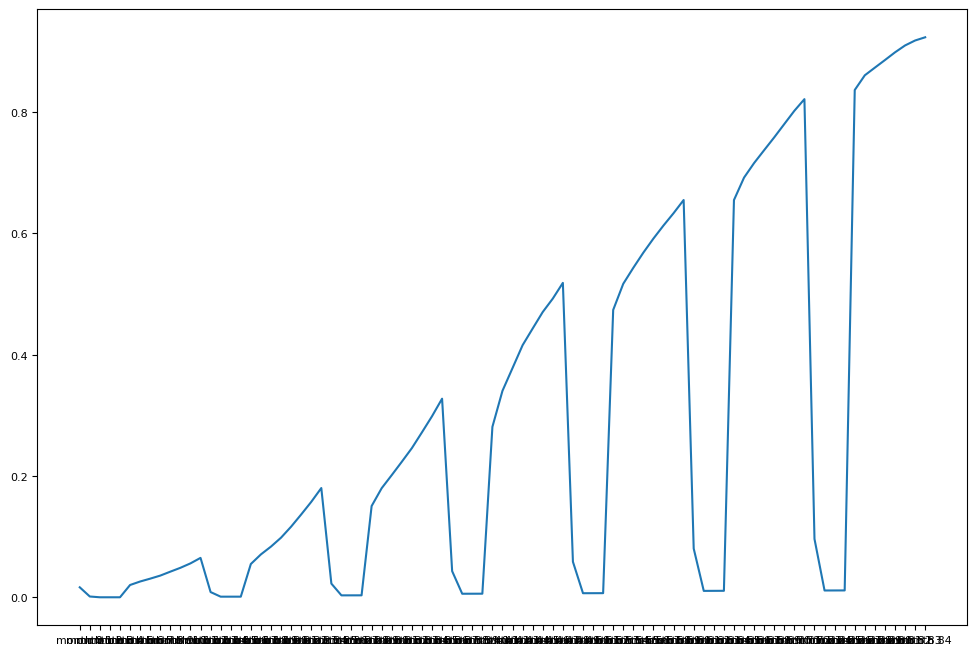

In [7]:
avg_df = visual_df.mean(axis=1)
plt.figure(figsize=(12,8))
plt.plot(avg_df.index, avg_df.iloc[0:, ])
plt.tick_params(labelsize=8)

--------------------------------
# 2. Running the Simulation as a Monte Carlo and Plotting the Results

With this line graph, we can run the simulation as many times as desired and compare the results.

This interactive graph shows different run modes, different experiment durations, and different numbers of simulations.

In [8]:
widgets.interact(model_variables,
    run_mode =['Baseline', 'Poison ToH', 'Population-Based', 'Quarantine'],
    sims_run = (10, 100, 10),
    sim_months = (1, 60, 1),
    value='Baseline',
    disabled=False,

)

interactive(children=(Dropdown(description='run_mode', options=('Baseline', 'Poison ToH', 'Population-Based', …

<function visualization_functions.model_variables(run_mode: str, sims_run: int, sim_months: int)>

------------------------------------------------
# 3. Model the Impact of a Experimental Variable Manipulation

After running multiple simulations on each model, the resulting average trend lines can be determined for each experimental varaible.

Note that these simulations are extended to 30 months to show longer-term trends.

In [9]:
sims_run = 100  # RIP my RAM
sim_months = 72

all_trends = {}

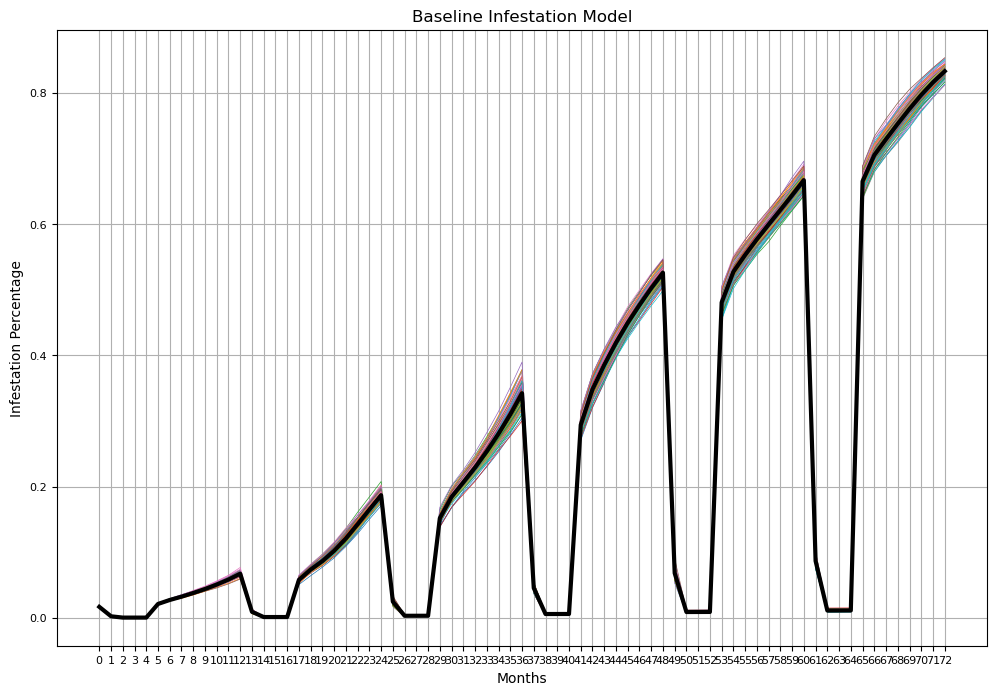

In [10]:
all_trends = model_variables_avg('Baseline', sims_run, sim_months, all_trends)

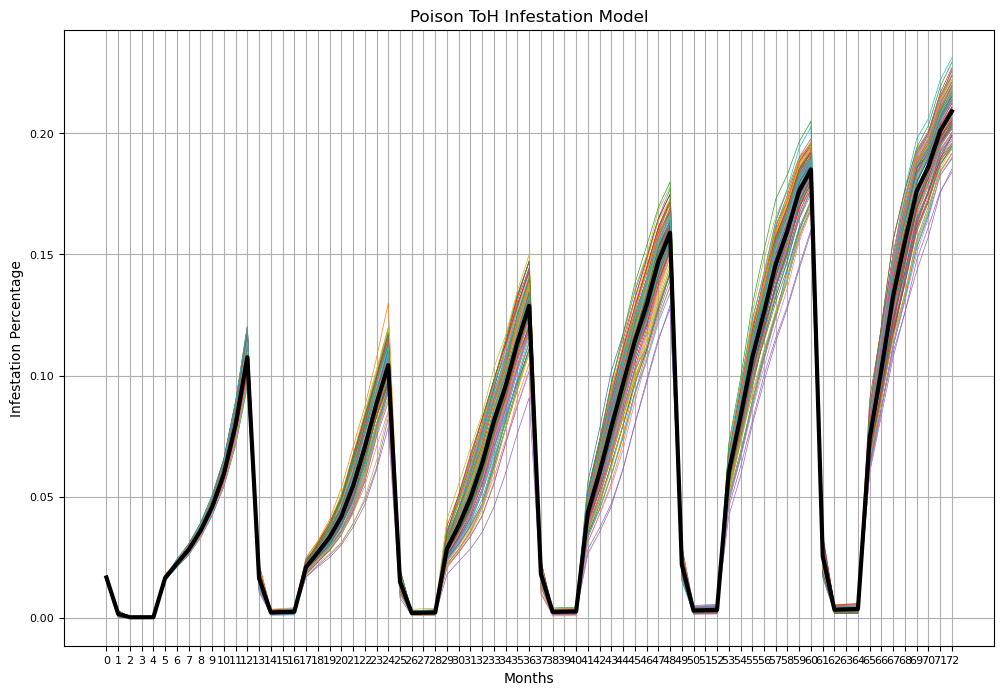

In [11]:
all_trends = model_variables_avg('Poison ToH', sims_run, sim_months, all_trends)

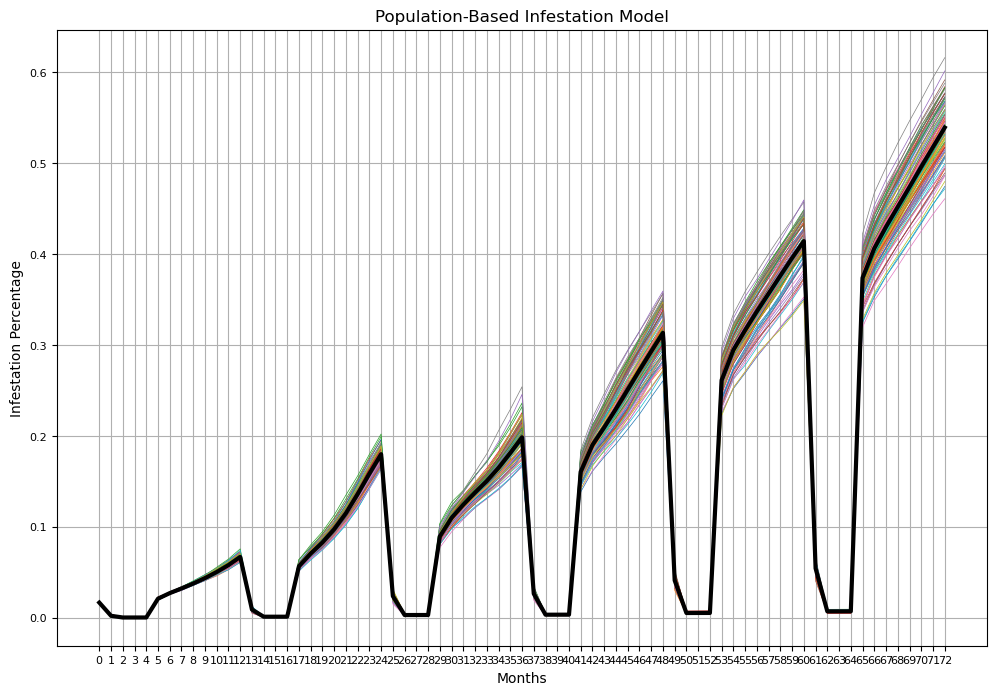

In [12]:
all_trends = model_variables_avg('Population-Based', sims_run, sim_months, all_trends)

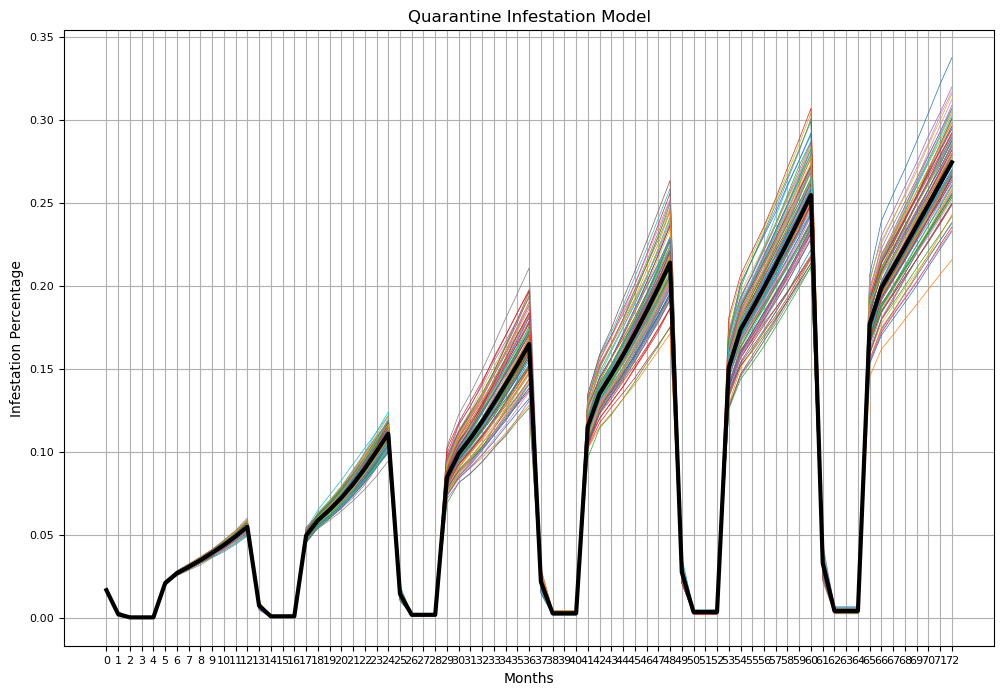

In [13]:
all_trends = model_variables_avg('Quarantine', sims_run, sim_months, all_trends)

-----------------------------------------------
# 4. Compare Average Trend Lines to Determine Efficacy of Interventions

By comparing the derived trend lines, the effect of each proposed intervention can be compared.

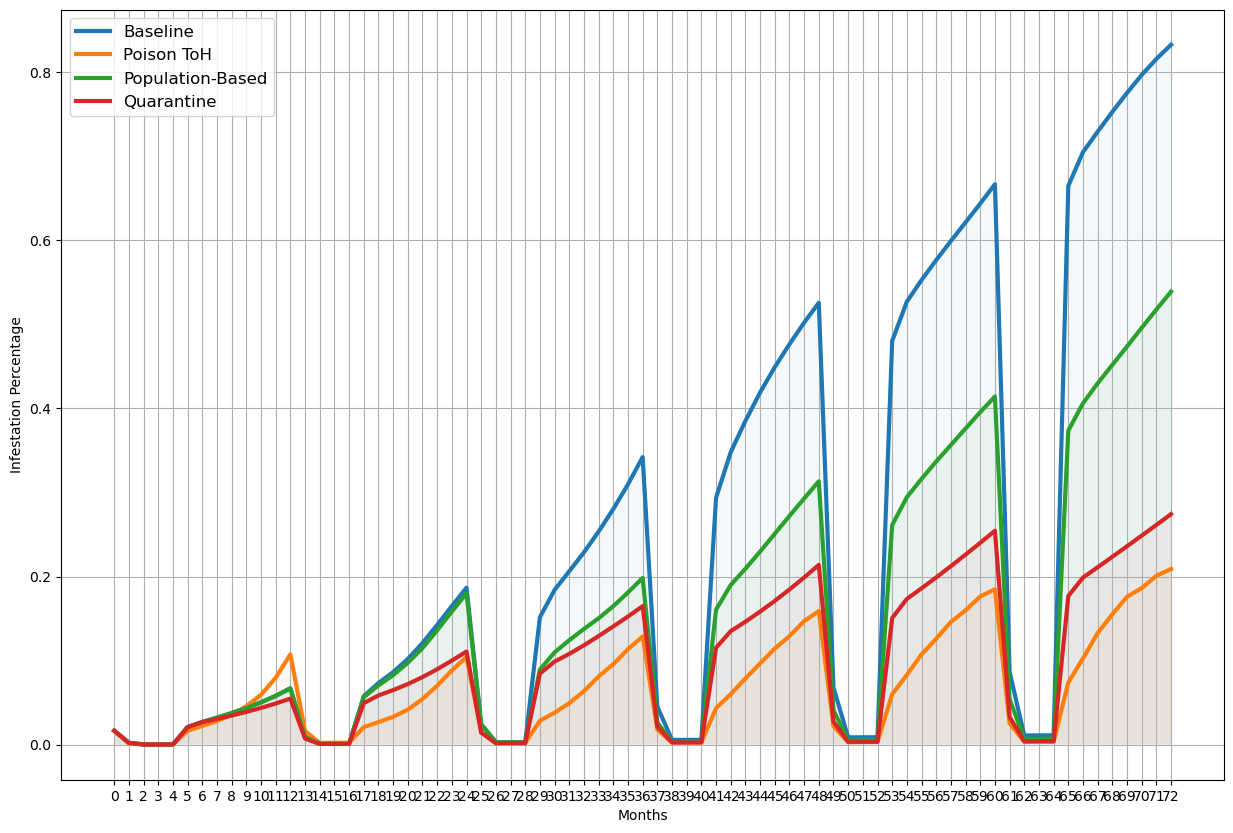

In [14]:
fig, ax = plt.subplots(figsize=(15, 10))

plt.xticks(ticks=range(0, sim_months+1),
            labels=range(0, sim_months+1))
plt.xlabel('Months')
plt.ylabel('Infestation Percentage')

for model in all_trends:
    trend_sr = all_trends[model]
    X = trend_sr.index.tolist()
    Y = trend_sr.values.tolist()
    
    ax.plot(X, Y, label=model, linewidth=3)
    ax.fill_between(X, Y, 0, alpha=0.05, interpolate=True)

plt.grid()
plt.legend(fontsize=12)
plt.show()

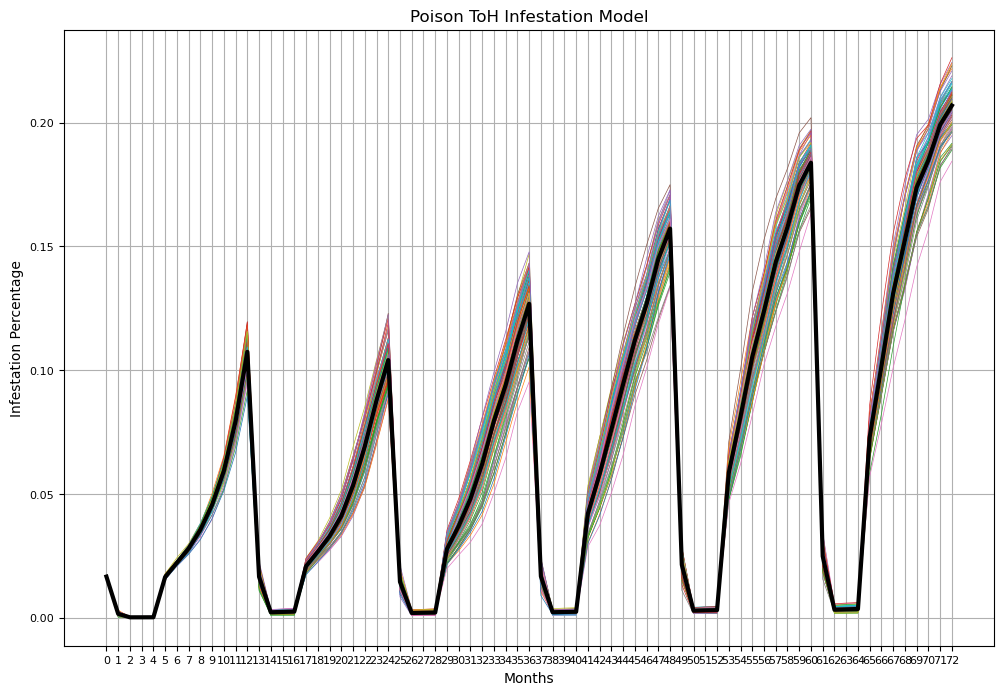

In [15]:
all_trends = model_variables_avg('Poison ToH', sims_run, sim_months, all_trends)

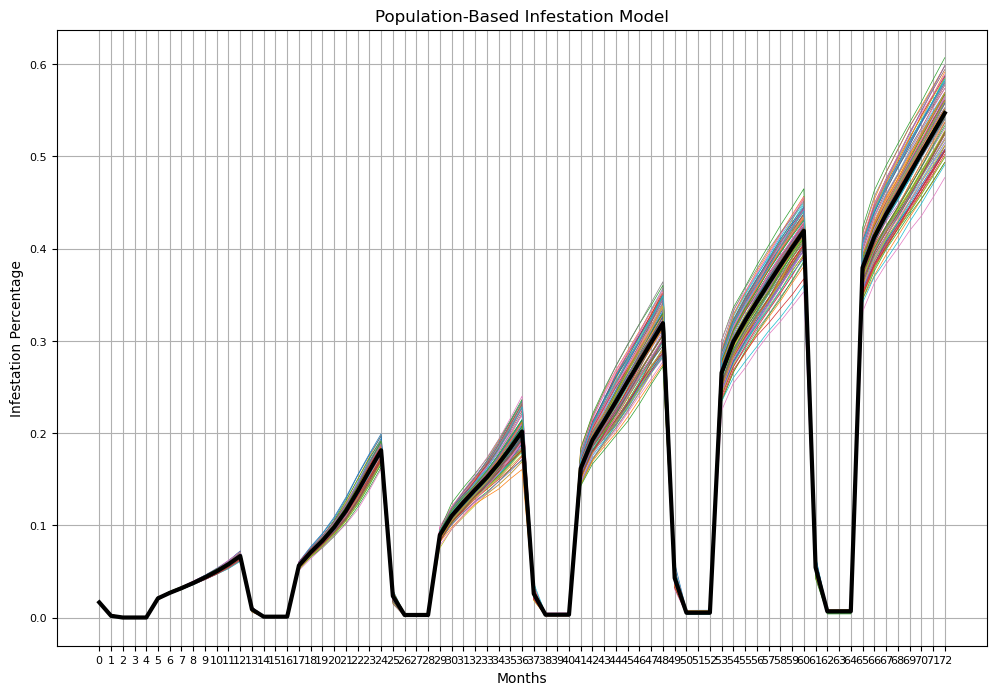

In [16]:
all_trends = model_variables_avg('Population-Based', sims_run, sim_months, all_trends)

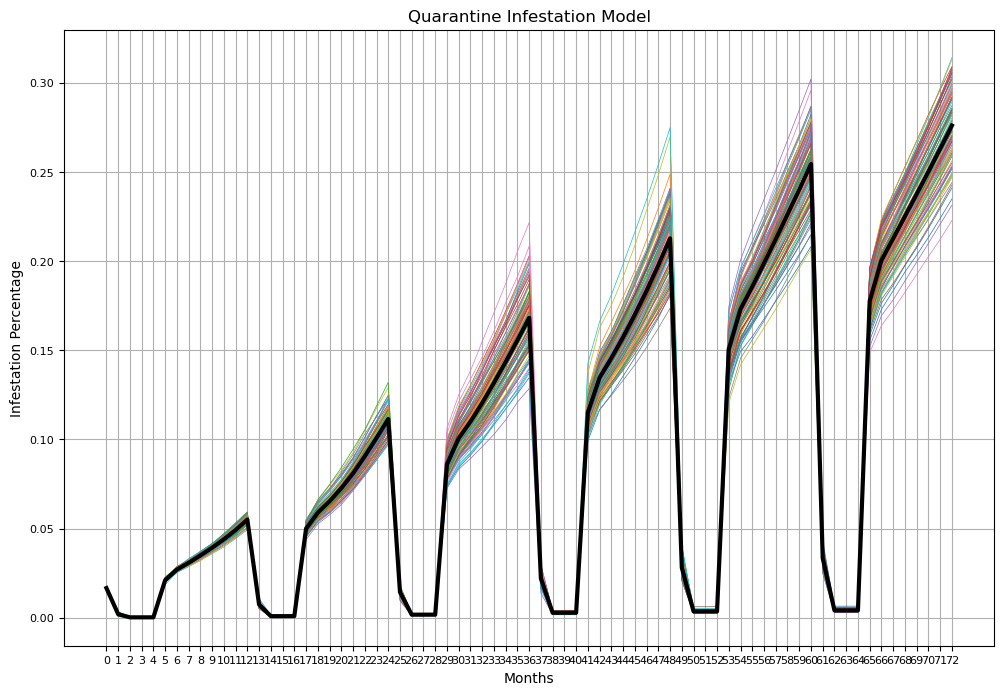

In [17]:
all_trends = model_variables_avg('Quarantine', sims_run, sim_months, all_trends)

-----------------------------------------------
# 4. Compare Average Trend Lines to Determine Efficacy of Interventions

By comparing the derived trend lines, the effect of each proposed intervention can be compared.

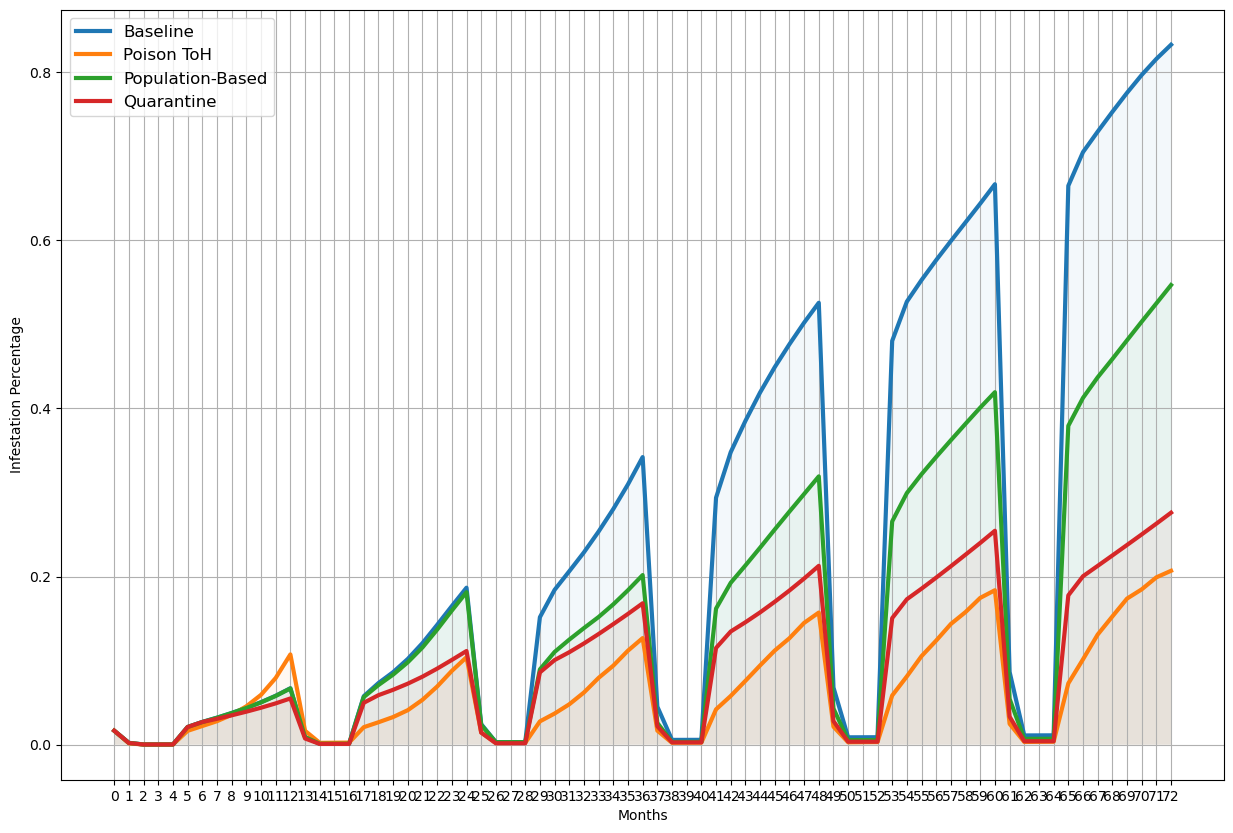

In [18]:
fig, ax = plt.subplots(figsize=(15, 10))

plt.xticks(ticks=range(0, sim_months+1),
            labels=range(0, sim_months+1))
plt.xlabel('Months')
plt.ylabel('Infestation Percentage')

for model in all_trends:
    trend_sr = all_trends[model]
    X = trend_sr.index.tolist()
    Y = trend_sr.values.tolist()
    
    ax.plot(X, Y, label=model, linewidth=3)
    ax.fill_between(X, Y, 0, alpha=0.05, interpolate=True)

plt.grid()
plt.legend(fontsize=12)
plt.show()